In [572]:
%matplotlib inline
from __future__ import print_function
from torch.autograd import Variable
from random import randint
import torch
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output
import csv

In [573]:
images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) # reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

In [574]:
# push non apple classes to 1
for k in range(len(labels)):
    if labels[k] != 0:
        labels[k] = 1
    else:
        labels[k] = 0
        
# normalize on z score
images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)

# split data into train, dev, test
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

In [575]:
class Network():
    
    def __init__(self, learning_rate, iterations):
        self.num_input_features = None
        self.lr = learning_rate #learning rate
        self.iterations = iterations #num iterations
        self.count = 0
        self.num_iterations_vals = []
        self.accuracy_vals_train = []
        self.accuracy_vals_dev = []
        self.total_iterations = 0

    def accuracy(self, y, y_hat):
        return (y == y_hat).astype(np.float).mean()
        
    def fit(self, X, Y, X_dev, Y_dev):
        self.w1 = Variable(torch.rand(X.shape[1], 40).type(torch.DoubleTensor), requires_grad=True) # 40 hidden nodes
        self.w2 = Variable(torch.rand(40, 1).type(torch.DoubleTensor), requires_grad=True)
        for j in range(self.iterations): #keep looping for iterations amount of times
            for i in range(X.shape[0]):
                if (self.count == 100):
                    self.total_iterations += 100
                    self.count = 0
                    y_hat_train = np.zeros(1000)
                    y_actual = np.zeros(1000)
                    y_hat_dev = np.zeros(1000)
                    y_actual_dev = np.zeros(1000)
                    for z in range(1000):
                        rand_int = randint(0, 39999) # random ints
                        rand_int_dev = randint(0, 4999)
                        y_actual[z] = Y[rand_int]
                        y_actual_dev[z] = Y_dev[rand_int_dev]

                        # do the exact same thing as we do for the predictions in for loop
                        oo = X[rand_int].resize_(X[rand_int].shape[0], 1)
                        y_hat10 = oo.t().mm(self.w1.data)
                        y_hat11 = torch.sigmoid(y_hat10)
                        y_hat20 = y_hat11.mm(self.w2.data)
                        y_hat22 = torch.sigmoid(y_hat20)
                        #print(y_hat22)
                        kk = X_dev[rand_int_dev].resize_(X_dev[rand_int_dev].shape[0], 1)
                        y_hat33 = kk.t().mm(self.w1.data)
                        y_hat33 = torch.sigmoid(y_hat33)
                        y_hat44 = y_hat33.mm(self.w2.data)
                        y_hat44 = torch.sigmoid(y_hat44)
                        #print(y_hat44)
                        if (y_hat22 < .5).numpy(): # if less than 0, than apple
                            y_hat_train[z] = 0
                        else:
                            y_hat_train[z] = 1
                        if (y_hat44 < .5).numpy():
                            y_hat_dev[z] = 0
                        else:
                            y_hat_dev[z] = 1
                    self.num_iterations_vals.append(self.total_iterations) # for the plots
                    self.accuracy_vals_train.append(self.accuracy(y_actual, y_hat_train))
                    self.accuracy_vals_dev.append(self.accuracy(y_actual_dev, y_hat_dev))
                
                x = Variable(X[i].resize_(X[i].shape[0], 1)) # explicitly reshape to have extra dimension for matrix multiplication
                y = Variable(torch.DoubleTensor([Y[i]]))
                y_hat1 = torch.sigmoid(torch.t(self.w1).mm(x)) # input -> hidden layer
                y_hat2 = torch.sigmoid(torch.t(self.w2).mm(y_hat1)) # hidden layer -> output
                loss = -1 * y * torch.log(y_hat2) - (1 - y) * torch.log(1 - y_hat2) # loss function cross entropy
                loss.backward()
                self.w1.data = self.w1.data - self.lr * self.w1.grad.data # updating
                self.w2.data = self.w2.data - self.lr * self.w2.grad.data
                self.w1.grad.data.zero_() # zero gradients
                self.w2.grad.data.zero_()
                self.count += 1

        return self

    def predict(self, X):
        y_hat = np.zeros(X.shape[0])
        csv = open("output.csv", "w") # output file
        firstrow = "id,label\n" # headers
        csv.write(firstrow)
        for i in range(X.shape[0]):
            x = X[i].resize_(X[i].shape[0], 1)
            y_hat55 = torch.sigmoid(x.t().mm(self.w1.data))
            y_hat66 = torch.sigmoid(y_hat55.mm(self.w2.data)) # hidden layer -> output
            #print(y_hat2)
            if (y_hat66 < .5).numpy(): # predictions
                csv.write(str(i) + ",0\n")
                y_hat[i] = 0
            else:
                csv.write(str(i) + ",1\n")
                y_hat[i] = 1
        return y_hat

In [576]:
net = Network(.1, 1) # learning rate .1 helps learning, otherwise not enough learning happens
train_data = train_data.type(torch.DoubleTensor)
dev_data = dev_data.type(torch.DoubleTensor)
net.fit(train_data, train_labels, dev_data, dev_labels)

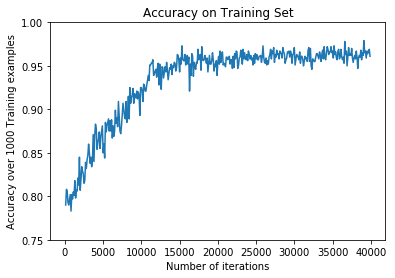

In [577]:
plt.plot(net.num_iterations_vals, net.accuracy_vals_train)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.ylim(.75,1.00)
plt.show()

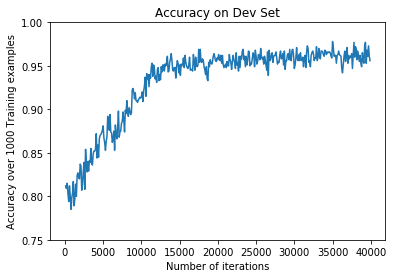

In [578]:
plt.plot(net.num_iterations_vals, net.accuracy_vals_dev)
plt.title("Accuracy on Dev Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.ylim(.75,1.00)
plt.show()

There is no overfitting happening; there is no decrease in performance with continued training. 

In [581]:
# This creates the Kaggle submission
more_images = np.load("test_images.npy")
num_images, height, width = more_images.shape
more_images = more_images.reshape(num_images, height*width) # reshape
more_images = torch.from_numpy(more_images).type(torch.DoubleTensor)

more_images = more_images.type(torch.DoubleTensor)
more_images = (more_images - torch.mean(more_images))/torch.std(more_images)

net.predict(more_images)

array([ 1.,  1.,  0., ...,  0.,  1.,  1.])

My Kaggle username is rohantilva. The Kaggle submission I made was under username rohantilva with output.csv.